In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
%matplotlib inline

In [3]:
pos = pos.groupby('SK_ID_CURR').\
        apply(lambda x: x.sort_values(['MONTHS_BALANCE'], ascending=False)).\
        reset_index(drop=True)

In [2]:
pos = pd.read_csv('../input/POS_CASH_balance.csv')

## Feature Description
**SK_ID_PREV:** ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)

**SK_ID_CURR:** ID of loan in our sample

**MONTHS_BALANCE:** Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly ), time only relative to the application

**CNT_INSTALMENT:** Term of previous credit (can change over time)

**CNT_INSTALMENT_FUTURE:** Installments left to pay on the previous credit

**NAME_CONTRACT_STATUS:** Contract status during the month

**SK_DPD:** DPD (days past due) during the month of previous credit

**SK_DPD_DEF:** DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

In [4]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1369693,100001,-53,4.0,0.0,Completed,0,0
1,1369693,100001,-54,4.0,1.0,Active,0,0
2,1369693,100001,-55,4.0,2.0,Active,0,0
3,1369693,100001,-56,4.0,3.0,Active,0,0
4,1369693,100001,-57,4.0,4.0,Active,0,0


In [4]:
pos.isnull().sum() / len(pos)

SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.002607
CNT_INSTALMENT_FUTURE    0.002608
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64

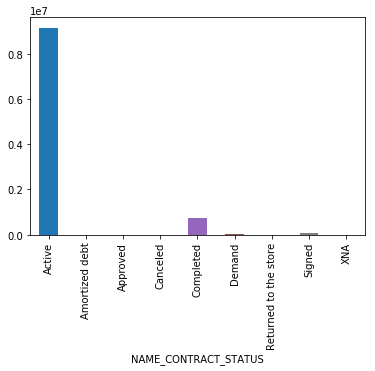

In [5]:
pos.groupby('NAME_CONTRACT_STATUS')['SK_ID_CURR'].count().plot(kind='bar')

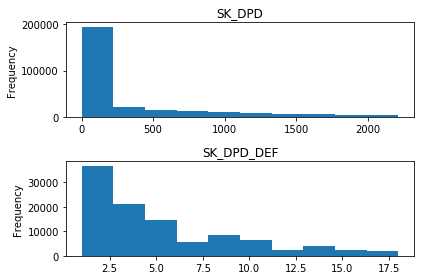

In [6]:
for i, col in enumerate(['SK_DPD', 'SK_DPD_DEF'], 1):
    plt.subplot(2, 1, i)
    upbnd = pos[col].quantile(.999)
    lowbnd = pos[col].quantile(.001)
    pos[(pos[col]>lowbnd) & (pos[col]<upbnd)][col].plot(kind='hist')
    plt.title(col)
plt.tight_layout()

<font size=5> NOTE: Each user in current application only has ONE credit in pos dataset

In [7]:
(pos.groupby('SK_ID_PREV')['SK_ID_PREV'].nunique() > 1).sum()

0

In [5]:
pos[pos['SK_ID_PREV']==1000005]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2131518,1000005,176456,-46,10.0,0.0,Completed,0,0
2131519,1000005,176456,-47,10.0,1.0,Active,0,0
2131520,1000005,176456,-48,10.0,2.0,Active,0,0
2131521,1000005,176456,-49,10.0,3.0,Active,0,0
2131522,1000005,176456,-50,10.0,4.0,Active,0,0
2131523,1000005,176456,-51,10.0,5.0,Active,0,0
2131524,1000005,176456,-52,10.0,6.0,Active,0,0
2131525,1000005,176456,-53,10.0,7.0,Active,0,0
2131526,1000005,176456,-54,10.0,8.0,Active,0,0
2131527,1000005,176456,-55,10.0,9.0,Active,0,0


In [10]:
latest_status = {}
for sk_id, df in pos.groupby('SK_ID_CURR'):
    min_ = df['CNT_INSTALMENT_FUTURE'].min()
    if pd.isnull(min_):
        if len(df) == 1:
            latest_status[sk_id] = df['NAME_CONTRACT_STATUS'].values[0]
        else:
            latest_status[sk_id] = np.nan
    else:
        latest_status[sk_id] = df[df['CNT_INSTALMENT_FUTURE'] == min_]['NAME_CONTRACT_STATUS'].values[0]

In [12]:
def one_hot_encoding(df, nan_as_category):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [35]:
pos_agg = pd.DataFrame()
pos_agg['LATEST_STATUS'] = pd.Series(latest_status)
pos_agg, _ = one_hot_encoding(pos_agg, nan_as_category=True)

In [38]:
pos, cat_cols = one_hot_encoding(pos, nan_as_category=True)
# Features
aggregations = {
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'SK_DPD': ['max', 'mean', 'sum'],
    'SK_DPD_DEF': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['sum', 'mean']

pos_agg_auto = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg_auto.columns = pd.Index(
    ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg_auto.columns.tolist()])

pos_agg = pos_agg.join(pos_agg_auto)
pos_agg['POS_REC_COUNT'] = pos.groupby('SK_ID_CURR').size()
pos_agg['POS_AVG_DPD'] = pos_agg['POS_SK_DPD_SUM'] / pos_agg['POS_REC_COUNT']
pos_agg['POS_AVG_DPD_DEF'] = pos_agg['POS_SK_DPD_DEF_SUM'] / pos_agg['POS_REC_COUNT']
del pos, pos_agg_auto
gc.collect()

161

In [39]:
for col in pos_agg.columns: 
    print(col)

LATEST_STATUS_Active
LATEST_STATUS_Amortized debt
LATEST_STATUS_Approved
LATEST_STATUS_Completed
LATEST_STATUS_Demand
LATEST_STATUS_Returned to the store
LATEST_STATUS_Signed
LATEST_STATUS_nan
POS_MONTHS_BALANCE_MIN
POS_MONTHS_BALANCE_MAX
POS_MONTHS_BALANCE_MEAN
POS_SK_DPD_MAX
POS_SK_DPD_MEAN
POS_SK_DPD_SUM
POS_SK_DPD_DEF_MAX
POS_SK_DPD_DEF_MEAN
POS_SK_DPD_DEF_SUM
POS_NAME_CONTRACT_STATUS_Active_SUM
POS_NAME_CONTRACT_STATUS_Active_MEAN
POS_NAME_CONTRACT_STATUS_Amortized debt_SUM
POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN
POS_NAME_CONTRACT_STATUS_Approved_SUM
POS_NAME_CONTRACT_STATUS_Approved_MEAN
POS_NAME_CONTRACT_STATUS_Canceled_SUM
POS_NAME_CONTRACT_STATUS_Canceled_MEAN
POS_NAME_CONTRACT_STATUS_Completed_SUM
POS_NAME_CONTRACT_STATUS_Completed_MEAN
POS_NAME_CONTRACT_STATUS_Demand_SUM
POS_NAME_CONTRACT_STATUS_Demand_MEAN
POS_NAME_CONTRACT_STATUS_Returned to the store_SUM
POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN
POS_NAME_CONTRACT_STATUS_Signed_SUM
POS_NAME_CONTRACT_STATUS_S

In [40]:
len(pos_agg.columns)

40

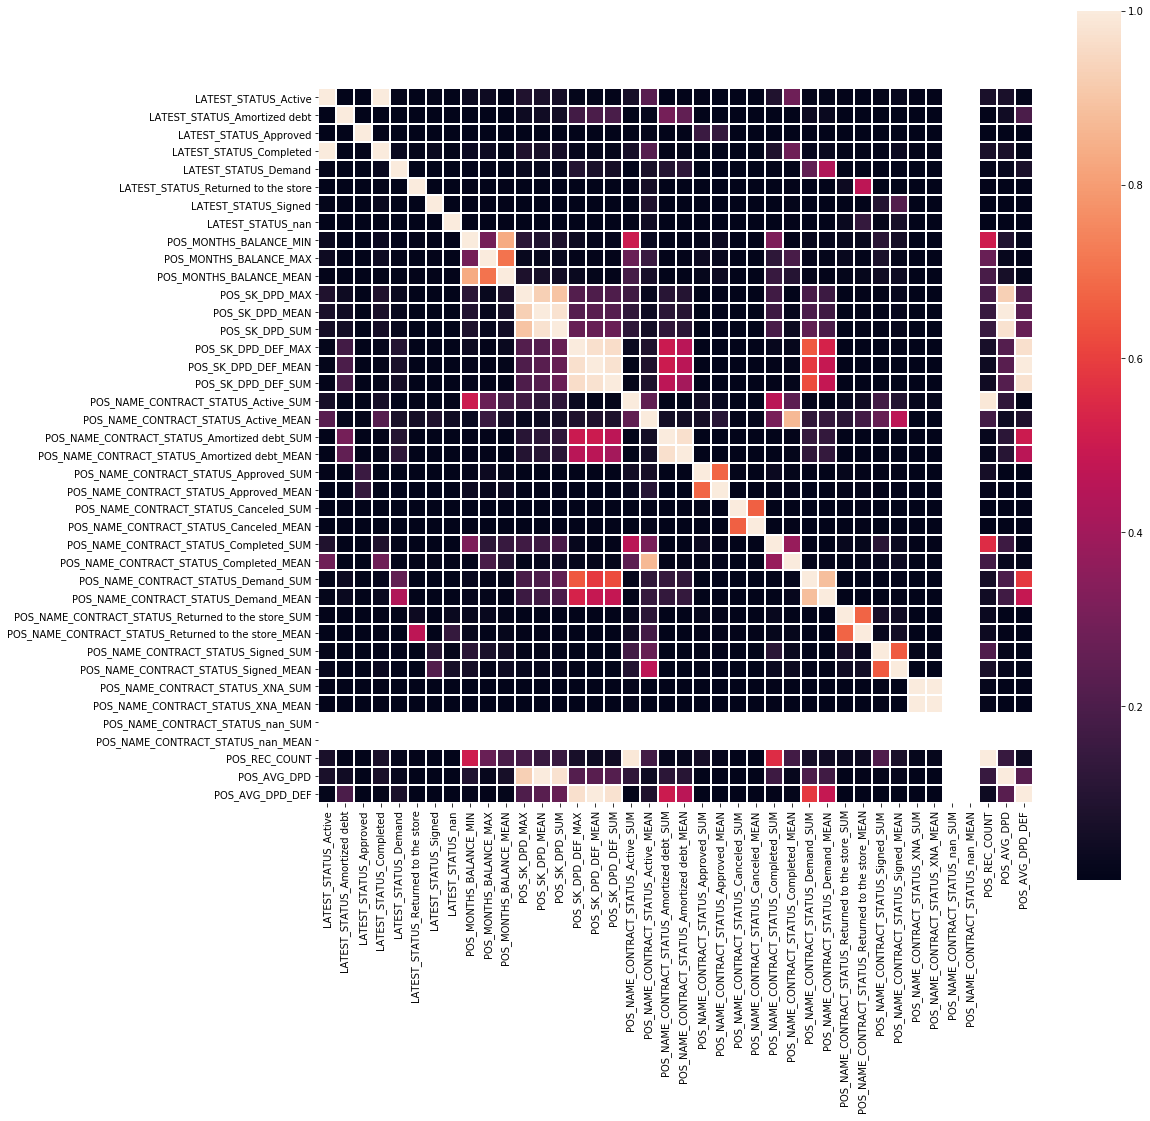

In [41]:
plt.figure(figsize=(16, 16))
sns.heatmap(abs(pos_agg.corr()), linewidths=1, square=1)